In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

INPUT = '/scratch/users/k21075402'
harvest = {
    'folder': 'new',
    'name': 'commons_harvest__open',
    'TRIAL_IDS_SP': ['39596646', '3f82a7f6', 'b484e613', 'd1a59a0e', 'ebcd23ed'],
    'TRIAL_IDS_ID': ['41697eb3', '68238f61', 'b0569bd9', 'd1ec3174', 'eb100aee'],
    'n': 7,
    'ylim': 800,
    'scratch_id': '30ca9764',
}
mushroom = {
    'folder': 'tf_2_14',
    'name': 'externality_mushrooms__dense',
    # 'TRIAL_IDS_ID': ['ec5de638']}
    'TRIAL_IDS_ID': ['8de7e630', 'b7c04d31', 'ca8d5c9d', 'cb2f86c9', 'fba0fc0e'],
    'n': 5,
    'ylim': 1000,
    'scratch_id': '51727c4c',
}

window = 11
epochs = 300

In [26]:
def load_df(trial_id: str, *, environment: dict[str], independent: bool=False, self_interest: float=None):
    df = pd.read_json(os.path.join(INPUT, environment['folder'], environment['name'], trial_id, 'results.json'), lines=True)
    df['reward'] = df.episode_reward.apply(lambda x: np.mean(x))
    df['trial_id'] = trial_id
    if self_interest is None:
        df = df[(df['num_players'] == environment['n'])]
        df = df.sort_values(by=['self-interest', 'training_iteration'], ascending=[False, True])
        df = df.reset_index(drop=True)
        df['iteration'] = df.index + 1
    else:
        df = df[(df['self-interest'] == self_interest)]
        df['iteration'] = df.training_iteration + 300 * (df.num_players - 1)

    df = df.drop(columns=['training_iteration', 'episode_reward', 'episode_lengths'])
    if independent:
        df = df.drop(columns=df.filter(regex='policy_player_').columns)
    else:
        df = df.drop(columns=['policy_default_reward'])
    return df

In [27]:
def plot_num_players(df, environment, rolling: bool = False):
    grouped = df.groupby('trial_id')

    # Plot each group
    fig, ax = plt.subplots(figsize=(4.8, 1.9), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, environment['n'])]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)
    
    ax.set_xlabel('Environment steps (million)')
    ax.set_title('Number of players', fontsize=10, y=1.1)
    ax.set_ylabel('Social welfare')
    step_size = 300
    ax.set_xlim(0, environment['n'] * step_size)
    ax.set_ylim(0, environment['ylim'])
    ax.set_xticks(np.arange(0, environment['n'] * step_size + 1, step_size))
    ax.set_xticklabels(np.arange(0, environment['n'] * step_size * 30 * 2000 / 1e6 + 1, step_size * 30 * 2000 / 1e6).astype(int))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())  # Make sure the limits are the same
    ax2.set_yticks(ax.get_yticks())  # Duplicate the tick marks
    
    regions = dict((str(i), i * step_size) for i in range(1, environment['n'] + 1))
    
    for region, position in regions.items():
        # ax.axvline(x=position, color='gray', linestyle='--', alpha=0.5)
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax

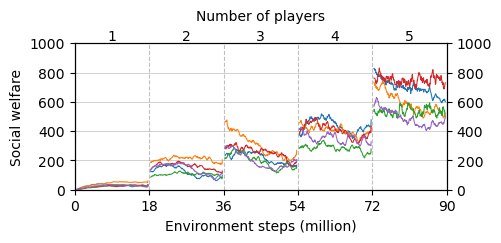

In [28]:
self_interest = 1
independent = True
rolling = True
environment = mushroom

tids = environment['TRIAL_IDS_ID'] if independent else environment['TRIAL_IDS_SP']
df = pd.concat([load_df(t, environment=environment, independent=independent, self_interest=self_interest) for t in tids])

fig, ax = plot_num_players(df, environment, rolling)

mode = 'independent' if independent else 'self_play'
name = f'num_players_{mode}_{environment["name"]}'
if rolling:
    name += '_rolling'
fig.savefig(name, dpi=300, bbox_inches='tight')

In [29]:
def plot_self_interest(df, envrionment, rolling: bool = False):
    grouped = df.groupby('trial_id')

    fig, ax = plt.subplots(figsize=(4.8, 1.9), facecolor='white')
    for name, group in grouped:
        if rolling:
            result = group['reward'].rolling(window=window, center=True).mean()
            indices = [list(range(epochs*i - window//2 + 1, epochs*i + window//2 +1)) for i in range(1, 10)]
            # TODO: remove
            indices = [idx for sublist in indices for idx in sublist if 0 <= idx < len(result)]
            result.iloc[indices] = np.nan
            result.plot(ax=ax, label=name, legend=False, lw=0.75)
        else:
            group.plot(x='iteration', y='reward', ax=ax, label=name, legend=False, lw=0.75)

    ax.set_xlabel('Environment steps (million)')
    ax.set_title('Self-interest', fontsize=10, y=1.1)
    ax.set_ylabel('Social welfare')
    step_size = 300
    ax.set_xlim(0, 10 * step_size)
    ax.set_ylim(0, environment['ylim'])
    ax.set_xticks(np.arange(0, 10 * step_size + 1, step_size))
    ax.set_xticklabels(np.arange(0, 10 * step_size * 30 * 2000 / 1e6 + 1, step_size * 30 * 2000 / 1e6).astype(int))
    ax.yaxis.grid(True, linestyle='-', linewidth=0.5, color='grey', alpha=0.5)
    ax.xaxis.grid(True, color='grey', linestyle='--', alpha=0.5)
    
    # ax2 = ax.twinx()
    # ax2.set_ylim(ax.get_ylim())
    # ax2.set_yticks(ax.get_yticks())
    
    ratio = [20, 10, 5, 3, 5/2, 2, 5/3, 4/3, 1]
    regions = dict((f"{s:.2f}", (1+i) * 300) for i, s in enumerate([1] + [r/(environment['n'] + r - 1) for r in ratio]))
    
    for region, position in regions.items():
        ax.text(position-150, 1.02, region, transform=ax.get_xaxis_transform(), horizontalalignment='center')

    return fig, ax


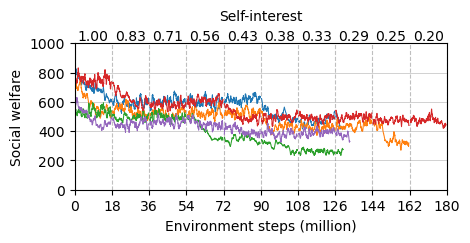

In [30]:
independent = True
rolling = True
environment = mushroom

tids = environment['TRIAL_IDS_ID'] if independent else environment['TRIAL_IDS_SP']
df = pd.concat([load_df(t, environment=environment, independent=independent) for t in tids])


fig, ax = plot_self_interest(df, environment, rolling=rolling)

mode = 'independent' if independent else 'self_play'
name = f'self_interest_{mode}_{environment["name"]}'
if rolling:
    name += '_rolling'
fig.savefig(name, dpi=300, bbox_inches='tight')

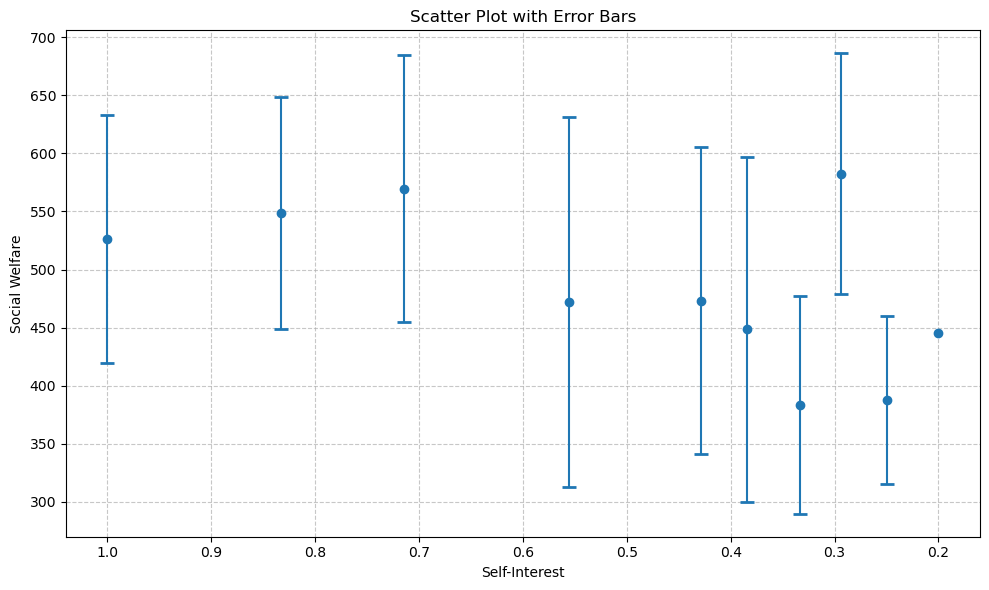

In [8]:
import matplotlib.pyplot as plt
import numpy as np

group = df[df['iteration'] % 300 == 0].groupby('iteration')

# Extract the data
x = group['self-interest'].mean()
y = group['reward'].mean()
yerr = group['reward'].std()

# Create the scatter plot with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(x, y, yerr=yerr, fmt='o', capsize=5, capthick=2)

# Set labels and title
plt.xlabel('Self-Interest')
plt.ylabel('Social Welfare')
plt.title('Scatter Plot with Error Bars')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Reverse the x-axis
plt.gca().invert_xaxis()

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
group = df[df['iteration'] % 300 == 0].groupby('self-interest')
df2 = pd.DataFrame(dict((f'{name:.3f}', data.values) for name, data in group['reward']))
df2

ValueError: All arrays must be of the same length

In [10]:
from scipy.stats import dunnett

best_group = df2[df2.mean().idxmax()]

data = pd.DataFrame({'mean': df2.mean(), 'std dev': df2.std(), 'dunnet': df2.apply(lambda x: dunnett(x, control=best_group, alternative='less').pvalue[0])}).T
# p values: the probability that we cannot reject the null hypothesis (the sample is not less than the control)
data

NameError: name 'df2' is not defined

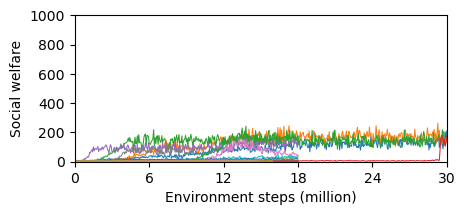

In [24]:
environment = mushroom
num_runs = 4  # 8 for commons harvest

df = pd.read_json(os.path.join(INPUT, environment['folder'], environment['name'], environment['scratch_id'], 'results.json'), lines=True)
df['reward'] = df.episode_reward.apply(lambda x: np.mean(x))

df = df[['reward', 'training_iteration', 'self-interest']]

# Hack for mushrooms
# though could loop over this and then like % over num of iterations == 1.
# df = 
fig, ax = plt.subplots(figsize=(4.8, 1.9), facecolor='white')

for s in df['self-interest'].unique():
    df_s = df[df['self-interest'] == s].copy()
    n = len(df_s[df_s['training_iteration'] == 1])


    df_s['id'] = df_s.index
    
    df_s = df_s.sort_values(['training_iteration', 'id'], kind='mergesort')
    df_s = df_s.reset_index(drop=True)
    
    df_s['run'] = df_s.index % n
    
    grouped = df_s.groupby('run')
    
    # Plot each group
    for run, group in grouped:
        group.plot(x='training_iteration', y='reward', ax=ax, label=run, legend=False, lw=0.75)

ax.set_xlabel('Environment steps (million)')
ax.set_ylabel('Social welfare')
step_size = 500
ax.set_xlim(0, step_size)
ax.set_ylim(0, environment['ylim'])
ax.set_xticks(np.arange(0, step_size + 1, step_size/5))
ax.set_xticklabels(np.arange(0, step_size * 30 * 2000 / 1e6 + 1, step_size/5 * 30 * 2000 / 1e6).astype(int))
 
fig.savefig(f'scratch_{environment["name"]}', dpi=300, bbox_inches='tight')

In [19]:
df['self-interest'].unique()

array([1.  , 0.43, 0.56, 0.71, 0.83, 0.38, 0.33, 0.29, 0.25, 0.2 ])

In [21]:
df_s = df[df['self-interest'] == 1]
len(df_s[df_s['training_iteration'] == 1]

,reward,training_iteration,self-interest,id,run
0,7.223333,1,1.0,0,0
1,5.686667,1,1.0,500,1
2,1.186667,1,1.0,1000,2
11,4.483333,1,1.0,3078,3
